<a href="https://colab.research.google.com/github/AnitaKirkovska/Bio_Project_Portfolio/blob/master/model_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make the Model

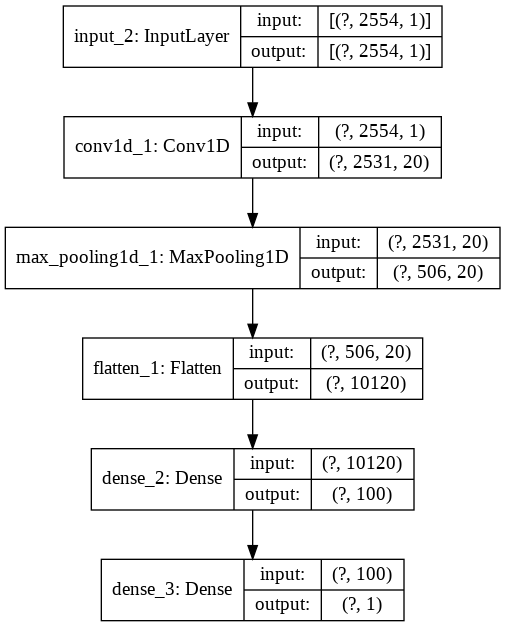

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv1D, Conv2D, BatchNormalization, MaxPool1D, Concatenate
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

"""
# build the imag CNN
vgg = VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)
img_base = vgg.output
img_base = Flatten()(img_base)
img_base = Dense(4096)(img_base)
"""

# Build the hyperspec 1DCNN
hyperspec_input = Input(shape=(2554, 1))
hyperspec_base = Conv1D(filters=20, kernel_size=24, strides=1, padding='valid', activation='tanh')(hyperspec_input)
hyperspec_base = MaxPool1D(pool_size=5, strides=None)(hyperspec_base)
hyperspec_base = Flatten()(hyperspec_base)
#hyperspec_base = Dense(512)(hyperspec_base)

"""
# Combine the feature maps
combined = Concatenate()([img_base, hyperspec_base])
"""
z = Dense(100, activation='tanh')(hyperspec_base)
z = Dense(1, activation = 'sigmoid')(z)

# Create the full model
model = Model(hyperspec_input, z)
plot_model(model, show_shapes=True, show_layer_names=True)

# Upload Data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


## Unzip Data

In [0]:
!unzip Data.zip

# Seperate Data into Control and Nitrogen

In [0]:
import os
import glob

# {'control' : set(ctrl_plant_name1, ctrl_plant_name2, ...)
#	'nitrogen' : set(nitrogen_plant_name1, nitrogen_plant_name2, ...)}
plants = {'control': set(), 'nitrogen':set()}

# {plant_name1 : [plant_name1_hyperspec1, plant_name1_hyperspec2, ...],
#	plant_name2 : [plant_name2_hyperspec1, plant_name2_hyperspec2, ...]}
hyperspecs = {}

# {plant_name1 : [plant_name1_img1, plant_name1_img2, ...],
#	plant_name2 : [plant_name2_img1, plant_name2_img2, ...]}
imgs = {}

data_path = './Data'
data_path = os.path.abspath(data_path)
weeks = glob.glob(os.path.join(data_path, '*'))

# Returns the class of the plant, and the formatted plant name
def get_plant(filepath):
	filename = os.path.basename(filepath)
	split = filename.split('_')
	plant_name = split[0] + '_' + split[1] + '_' + split[2] + '_' + split[3] + '_' + split[4]
	plant_name = plant_name.upper()

	if (split[0] == 'c' or split[0] == 'C'):
		category = 'control'
	elif (split[0] == 'n' or split[0] == 'N'):
		category = 'nitrogen'
	else:
		print('Unknown Class:', filename)

	return [category, plant_name]


for week in weeks:
	hyperspec_files = glob.glob(os.path.join(week, 'Hyperspecs', '*'))
	img_files = glob.glob(os.path.join(week, 'Images', '*'))

	for hyperspec_file in hyperspec_files:
		category, plant_name = get_plant(hyperspec_file)
		plants[category].add(plant_name)

		h = hyperspecs.get(plant_name, [])
		h.append(hyperspec_file)
		hyperspecs[plant_name] = h

	for img_file in img_files:
		category, plant_name = get_plant(img_file)
		plants[category].add(plant_name)

		i = imgs.get(plant_name, [])
		i.append(img_file)
		imgs[plant_name] = i

print(hyperspecs)

print('Num Control', len(plants['control']))
print('Num Nitrogen', len(plants['nitrogen']))

# Data Generator

In [0]:
import os
import glob
import numpy as np
import tensorflow.keras as keras

class data_gen(keras.utils.Sequence):
	def get_data(self):
		# {'control' : set(ctrl_plant_name1, ctrl_plant_name2, ...)
		#	'nitrogen' : set(nitrogen_plant_name1, nitrogen_plant_name2, ...)}
		plants = {'control': [], 'nitrogen': []}

		# {plant_name1 : [plant_name1_hyperspec1, plant_name1_hyperspec2, ...],
		#	plant_name2 : [plant_name2_hyperspec1, plant_name2_hyperspec2, ...]}
		hyperspecs = {}

		data_path = './Data'
		data_path = os.path.abspath(data_path)
		weeks = glob.glob(os.path.join(data_path, '*'))

		for week in weeks:
			hyperspec_files = glob.glob(os.path.join(week, 'Hyperspecs', '*'))
			img_files = glob.glob(os.path.join(week, 'Images', '*'))

			for hyperspec_file in hyperspec_files:
				filename = os.path.basename(hyperspec_file)
				split = filename.split('_')
				plant_name = split[0] + '_' + split[1] + '_' + split[2] + '_' + split[3] + '_' + split[4]
				plant_name = plant_name.upper()

				if (split[0] == 'c' or split[0] == 'C'):
					category = 'control'
				elif (split[0] == 'n' or split[0] == 'N'):
					category = 'nitrogen'
				else:
					print('Unknown Class:', filename)

				plants[category].append(plant_name)

				h = hyperspecs.get(plant_name, [])
				h.append(hyperspec_file)
				hyperspecs[plant_name] = h

		return plants, hyperspecs


	def __init__(self, batch_size, dim):
		self.batch_size = int(batch_size // 2 * 2)
		self.dim = dim
		self.plants, self.hyperspecs = self.get_data()
		self.epoch_data = {}
		self.on_epoch_end()


	def __len__(self):
		num_plants = len(plants['control']) + len(plants['nitrogen'])
		return int(np.ceil(num_plants / self.batch_size))


	def on_epoch_end(self):
		self.epoch_data['control'] = np.random.choice(self.plants['control'], len(self.plants['control']), replace=False)
		self.epoch_data['nitrogen'] = np.random.choice(self.plants['nitrogen'], len(self.plants['nitrogen']), replace=False)


	def __getitem__(self, index):
		start = int(index * self.batch_size / 2)
		end = int((index + 1) * self.batch_size / 2)
		control_plants = self.epoch_data['control'][start:end].tolist()
		nitrogen_plants = self.epoch_data['nitrogen'][start:end].tolist()

		num_plants = len(control_plants) + len(nitrogen_plants)

		X = np.empty((num_plants, self.dim, 1))
		y = np.empty((num_plants, 1))

		for i, plant in enumerate(control_plants):
			X[i] = self.read_hyperspec(plant)
			y[i] = 0
		for j, plant in enumerate(nitrogen_plants):
			X[i+j+1] = self.read_hyperspec(plant)
			y[i+j+1] = 1

		return X, y


	def read_hyperspec(self, plant):
		filepath = np.random.choice(self.hyperspecs[plant], 1)[0]

		with open(filepath, 'r') as f:
			lines = [l.strip('\n\r') for l in f]

		found_delimiter = False
		for i, line in enumerate(lines):
			if line == '>>>>>Begin Spectral Data<<<<<':
				found_delimiter = True
				break

		if not found_delimiter:
			print('Hyperspec File NOT Formatted as Expected')
			print(file)
			quit()

		X = []
		data = lines[i+1:]
		for datum in data:
			wavelen, intense = datum.split('\t')
			X.append(float(intense))

		X = np.array(X).reshape((self.dim, 1))
		return X

# Train Model

In [0]:
from tensorflow.keras import optimizers
train_gen = data_gen(8, 2554)
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)

model.compile(loss='mean_absolute_error', optimizer=opt)
model.fit_generator(generator=train_gen, epochs=10000)

Streaming output truncated to the last 5000 lines.
Epoch 1343/10000
8/8 [==============================] - 0s 19ms/step - loss: 0.3915
Epoch 1344/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.4222
Epoch 1345/10000
8/8 [==============================] - 0s 19ms/step - loss: 0.4378
Epoch 1346/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.4845
Epoch 1347/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.4688
Epoch 1348/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.4378
Epoch 1349/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.4221
Epoch 1350/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.4843
Epoch 1351/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.4533
Epoch 1352/10000
8/8 [==============================] - 0s 18ms/step - loss: 0.3913
Epoch 1353/10000
8/8 [==============================] - 0s 17ms/step - loss: 0.4687
Epoch 1354/10000
8/8 [===